# Global Valuation Model (Bayesian v1.0)

In the previous part, we utilized regularized regression to obtain point estimates for house prices. While effective for general trends, these methods do not inherently quantify the **uncertainty** of our estimates.

In this section, we adopt the **Bayesian Paradigm**. Instead of treating model parameters (like the base price per square foot) as fixed, unknown constants, we treat them as **random variables** described by probability distributions.

### Model Specification

We begin by building a **Global Bayesian Regression Model**. "Global" implies that we are ignoring neighborhood distinctions for now, treating the entire city of Ames as a single market. This serves as the Bayesian counterpart to the OLS model in Part 1.

We model `Log_Sale_Price` ($y$) as a linear function of `Gr_Liv_Area` ($x$):

$$ y_i = \beta_0 + \beta_1 x_i + \epsilon_i $$

The errors $\epsilon_i$ are assumed to be normally distributed with precision $\lambda$ (where $\lambda = 1/\sigma^2$).

### Computational Approach: Gibbs Sampling vs. HMC
While modern Bayesian analysis often utilizes Hamiltonian Monte Carlo (HMC) or the No-U-Turn Sampler (NUTS) for complex, non-conjugate models, this specific problem structure allows for a more direct approach.

Because we have chosen **Conjugate Priors** (Normal priors for the mean, Gamma prior for the precision), the posterior distributions have known analytical forms (Conditional Normals and Conditional Gammas). This allows us to use **Gibbs Sampling**, which is computationally efficient and draws samples from the exact conditional distributions without the need for the gradient calculations required by HMC.

### The Conditionals
The Gibbs sampler iteratively updates parameters based on the following full conditional distributions:

1.  **Intercept ($\beta_0$):** Represents the baseline log-price.
    $$ p(\beta_0 | \beta_1, \lambda, \mathbf{y}, \mathbf{x}) \sim \mathcal{N}(M_0, S_0^2) $$
2.  **Slope ($\beta_1$):** Represents the price elasticity of living area.
    $$ p(\beta_1 | \beta_0, \lambda, \mathbf{y}, \mathbf{x}) \sim \mathcal{N}(M_1, S_1^2) $$
3.  **Precision ($\lambda$):** Represents the inverse variance of the noise.
    $$ p(\lambda | \beta_0, \beta_1, \mathbf{y}, \mathbf{x}) \sim \text{Gamma}(A_n, B_n) $$

***

In [1]:
# --- Setup and Path Definition ---
import sys
from pathlib import Path

# Find the project root by looking for the .git folder
PROJECT_ROOT = Path.cwd().resolve().parents[1]

# Define key paths
DATA_PATH = PROJECT_ROOT / "src" / "data"
SRC_PATH = PROJECT_ROOT / "src"

# Add the 'src' directory to sys.path to allow for module imports
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Path:    {DATA_PATH}")
# --- End of Setup ---

Project Root: /Users/Faheem/Desktop/IITH/Sem 5 Textbooks and Extras/PRML/Project
Data Path:    /Users/Faheem/Desktop/IITH/Sem 5 Textbooks and Extras/PRML/Project/src/data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv(DATA_PATH / 'processed' / 'post_eda_ames_data.csv')

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prepare Data for Simple Linear Regression ---
# We reuse the data from Part 1
y = df['Log_Sale_Price'].values
x = df['Gr_Liv_Area'].values
n = len(y)

# --- Priors ---
# We use weakly informative priors to allow the data to dominate the posterior.
# Betas: N(0, 100) -> Mean=0, Variance=100 (High variance = low certainty)
m0, s0_sq = 0, 100
m1, s1_sq = 0, 100

# Lambda: Gamma(0.1, 0.1) -> Broad prior for precision
a0, b0 = 0.1, 0.1

# --- Gibbs Sampler Settings ---
n_samples = 10000
burn_in = 2000

# --- Initialize Chains ---
beta0_samples = np.zeros(n_samples)
beta1_samples = np.zeros(n_samples)
lambda_samples = np.zeros(n_samples)

# Start values based on empirical data to speed up convergence
beta0_curr = np.mean(y)
beta1_curr = 0
lambda_curr = 1 / np.var(y)

# --- Run Gibbs Sampler ---
for i in range(n_samples):
    # 1. Update Intercept (beta_0)
    # The conditional mean and variance depend on the current residuals
    S0_sq = 1 / (1/s0_sq + n * lambda_curr)
    M0 = S0_sq * (m0/s0_sq + lambda_curr * np.sum(y - beta1_curr * x))
    beta0_curr = stats.norm.rvs(loc=M0, scale=np.sqrt(S0_sq))
    
    # 2. Update Slope (beta_1)
    S1_sq = 1 / (1/s1_sq + lambda_curr * np.sum(x**2))
    M1 = S1_sq * (m1/s1_sq + lambda_curr * np.sum(x * (y - beta0_curr)))
    beta1_curr = stats.norm.rvs(loc=M1, scale=np.sqrt(S1_sq))
    
    # 3. Update Precision (lambda)
    residuals = y - beta0_curr - beta1_curr * x
    An = a0 + n / 2
    Bn = b0 + 0.5 * np.sum(residuals**2)
    lambda_curr = stats.gamma.rvs(a=An, scale=1/Bn)
    
    # Store samples
    beta0_samples[i] = beta0_curr
    beta1_samples[i] = beta1_curr
    lambda_samples[i] = lambda_curr

# Discard burn-in samples to ensure we analyze the stationary distribution
beta0_post = beta0_samples[burn_in:]
beta1_post = beta1_samples[burn_in:]
sigma2_post = 1 / lambda_samples[burn_in:] # Convert precision to variance

print(f"Global Bayesian Model: Gibbs sampling finished. Kept {len(beta0_post)} samples.")

Global Bayesian Model: Gibbs sampling finished. Kept 8000 samples.


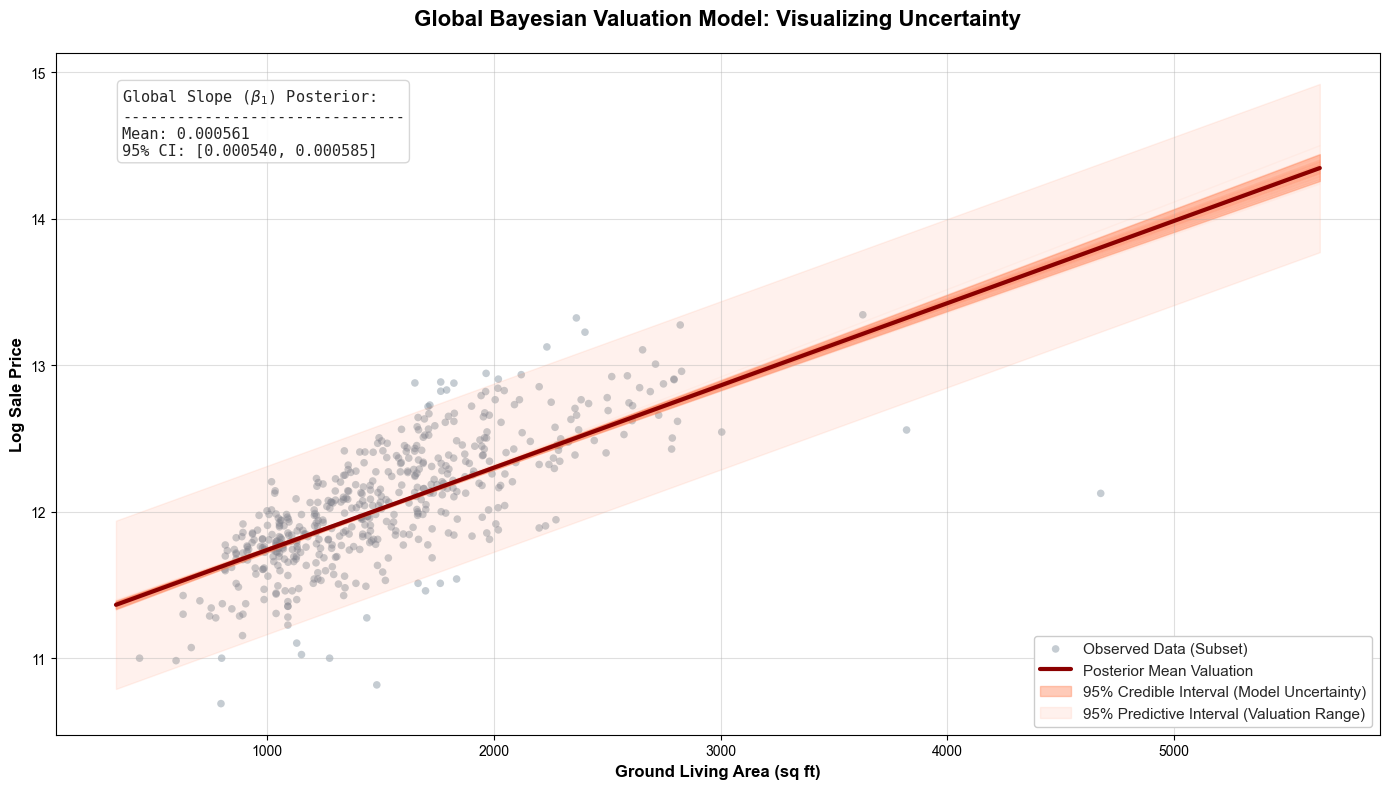

In [4]:
# --- Visualization of Posterior Uncertainty ---
fig, ax = plt.subplots(figsize=(14, 8))
sns.set_style("whitegrid")

# 1. Scatter plot of a subset of data (for visual clarity)
np.random.seed(42)
sample_indices = np.random.choice(len(x), size=500, replace=False)
ax.scatter(x[sample_indices], y[sample_indices], alpha=0.4, s=30, color='slategray', 
           label='Observed Data (Subset)', edgecolors='none')

# Create a grid of x values for prediction
x_grid = np.linspace(x.min(), x.max(), 200)

# 2. Visualize Parameter Uncertainty (The "Fuzzy" Regression Line)
# Plot individual regression lines from random posterior samples
np.random.seed(123)
n_lines = 100
random_idx = np.random.choice(len(beta0_post), size=n_lines, replace=False)

for idx in random_idx:
    y_line = beta0_post[idx] + beta1_post[idx] * x_grid
    ax.plot(x_grid, y_line, color='coral', alpha=0.05, linewidth=1)

# 3. Calculate Posterior Predictive Statistics
# We compute the line for every single posterior sample
y_pred_samples = np.zeros((len(beta0_post), len(x_grid)))
for i in range(len(beta0_post)):
    y_pred_samples[i, :] = beta0_post[i] + beta1_post[i] * x_grid

# Posterior Mean Line
y_mean = np.mean(y_pred_samples, axis=0)
ax.plot(x_grid, y_mean, color='darkred', linewidth=3, 
        label='Posterior Mean Valuation', zorder=10)

# 95% Credible Interval (Uncertainty about the average)
y_lower = np.percentile(y_pred_samples, 2.5, axis=0)
y_upper = np.percentile(y_pred_samples, 97.5, axis=0)
ax.fill_between(x_grid, y_lower, y_upper, color='coral', alpha=0.4, 
                 label='95% Credible Interval (Model Uncertainty)')

# 4. Posterior Predictive Interval (Uncertainty about a specific house)
# This includes the model uncertainty PLUS the noise variance (sigma^2)
mean_sigma = np.sqrt(np.mean(sigma2_post))
y_pred_lower = y_mean - 1.96 * mean_sigma
y_pred_upper = y_mean + 1.96 * mean_sigma

ax.fill_between(x_grid, y_pred_lower, y_pred_upper, color='coral', alpha=0.1, 
                 label='95% Predictive Interval (Valuation Range)')

# Annotations
beta1_mean = np.mean(beta1_post)
beta1_ci = np.percentile(beta1_post, [2.5, 97.5])

textstr = (
    f"Global Slope ($\\beta_1$) Posterior:\n"
    f"-------------------------------\n"
    f"Mean: {beta1_mean:.6f}\n"
    f"95% CI: [{beta1_ci[0]:.6f}, {beta1_ci[1]:.6f}]"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='lightgray')
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, family='monospace')

# Styling
ax.set_xlabel('Ground Living Area (sq ft)', fontsize=12, fontweight='bold')
ax.set_ylabel('Log Sale Price', fontsize=12, fontweight='bold')
ax.set_title('Global Bayesian Valuation Model: Visualizing Uncertainty', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11, framealpha=1)
ax.grid(True, alpha=0.4)

plt.savefig('global_uncertainty.png', dpi=300)
plt.tight_layout()
plt.show()

### Interpretation of the Bayesian Global Model

The plot above illustrates the two distinct types of uncertainty that the Bayesian framework allows us to quantify, which were absent in the Ridge/Lasso models:

1.  **Model Uncertainty (Darker Coral Band):** This represents our uncertainty about the *average* price of a home. Note how narrow this band is. Because we have a lot of data (nearly 3000 houses), we are extremely confident about the global average price per square foot.
2.  **Predictive Uncertainty (Lighter Coral Band):** This represents our uncertainty about the price of a *specific, individual* house. This band is much wider. It tells us that even if we know the square footage perfectly, there is still significant variation in price due to unobserved factors (quality, location, year built, etc.).

**The Limitation:**
While this model successfully captures uncertainty, it is still a **Global** model. It assumes that the relationship between size and price (the slope $\beta_1$) and the baseline price (the intercept $\beta_0$) is exactly the same for a luxury home in "Northridge" as it is for a fixer-upper in "Old Town."

To address this, we must move to **Hierarchical Modeling**, where we will introduce "Partial Pooling" to capture neighborhood-specific dynamics.

In [5]:
# Storing useful information for future analysis

import pickle

# Calculate the mean (since that's primarily what we need for the comparison)
global_mean_val = np.mean(beta0_post)

# Save the full posterior array AND the mean to a file
with open(DATA_PATH / 'analysis' / 'global_model_results.pkl', 'wb') as f:
    pickle.dump({
        'beta0_post': beta0_post, 
        'global_mean': global_mean_val
    }, f)

print(f"Global model data saved to 'global_model_results.pkl' in the analysis folder of {DATA_PATH}")

Global model data saved to 'global_model_results.pkl' in the analysis folder of /Users/Faheem/Desktop/IITH/Sem 5 Textbooks and Extras/PRML/Project/src/data
